In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

import tpvalidator.basic as tvb
import tpvalidator.utilities as utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import awkward as ak
import pandas as pd
import numpy as np



In [2]:
wf = utils.load_sparse_waveform_data('../data/vd/bkg/100events/trigger_digits_waves_detsim_vd_radiols.root')

[1]

1

found 32831 channels

Loading dataframe

Done loading dataframe

In [3]:
wf

,event,run,subrun,8,9,11,14,24,27,29,...,41463,41464,41465,41466,41467,41468,41469,41470,41471,sample_id
0,1,20000047,0,[7360 7362 7366 ... 7363 7366 7367],[7376 7372 7372 ... 7376 7376 7375],[7376 7372 7377 ... 7372 7371 7371],[7372 7365 7363 ... 7376 7374 7369],[7381 7379 7372 ... 7370 7373 7369],[7379 7373 7375 ... 7368 7371 7368],[7381 7382 7374 ... 7368 7363 7360],...,[1644 1644 1638 ... 1638 1638 1633],[1641 1641 1634 ... 1633 1644 1637],[1647 1655 1642 ... 1648 1654 1645],[1628 1637 1639 ... 1651 1655 1646],[1636 1645 1649 ... 1626 1630 1632],[1624 1625 1634 ... 1642 1653 1658],[1627 1630 1638 ... 1629 1619 1615],[1631 1629 1630 ... 1636 1636 1642],[1639 1638 1634 ... 1658 1659 1645],0


In [4]:
wf.columns

Index([    'event',       'run',    'subrun',           8,           9,
                11,          14,          24,          27,          29,
       ...
             41463,       41464,       41465,       41466,       41467,
             41468,       41469,       41470,       41471, 'sample_id'],
      dtype='object', length=32835)

In [51]:
c = list(wf.columns)
c.remove('event')
c.remove('run')
c.remove('subrun')
c.remove('sample_id')

In [52]:
x = {i:ak.to_numpy(wf[i].values[0]) for i in c}

In [53]:
k = {}

for i,a in x.items():
    l = len(a)
    j = k.setdefault(l, [])
    j += [i]

In [60]:
z = pd.DataFrame(x)

In [61]:
z

,8,9,11,14,24,27,29,30,33,34,...,41462,41463,41464,41465,41466,41467,41468,41469,41470,41471
0,7360,7376,7376,7372,7381,7379,7381,7361,7365,7388,...,1632,1644,1641,1647,1628,1636,1624,1627,1631,1639
1,7362,7372,7372,7365,7379,7373,7382,7361,7373,7389,...,1631,1644,1641,1655,1637,1645,1625,1630,1629,1638
2,7366,7372,7377,7363,7372,7375,7374,7369,7382,7378,...,1630,1638,1634,1642,1639,1649,1634,1638,1630,1634
3,7365,7368,7372,7367,7371,7366,7372,7379,7378,7374,...,1625,1644,1636,1640,1635,1651,1634,1637,1638,1629
4,7368,7370,7376,7369,7366,7367,7372,7385,7374,7368,...,1623,1640,1640,1629,1631,1646,1636,1637,1634,1626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,7366,7373,7367,7371,7379,7373,7371,7373,7368,7381,...,1631,1649,1630,1636,1640,1629,1630,1638,1630,1641
8496,7366,7376,7374,7369,7370,7370,7372,7372,7373,7380,...,1634,1647,1626,1638,1645,1626,1631,1638,1629,1651
8497,7363,7376,7372,7376,7370,7368,7368,7374,7373,7381,...,1640,1638,1633,1648,1651,1626,1642,1629,1636,1658
8498,7366,7376,7371,7374,7373,7371,7363,7377,7376,7371,...,1654,1638,1644,1654,1655,1630,1653,1619,1636,1659


In [ ]:
import uproot

def load_sparse_waveform_data(file_path: str, tree_name: str = 'triggerana/rawdigis_tree', ev_sel= 1):
    """Loads sparse rawdigits waveforms for a specific event from a ROOT file.

    Args:
        ev_num (int): Event number to load waveforms for.
        file_path (str): Path to the ROOT file containing the data.
        tree_name (str, optional): Name of the tree in the ROOT file. Defaults to 'triggerana/rawdigis_tree'.

    Returns:
        pd.DataFrame or None: DataFrame containing the waveforms for the specified event, or None if not found or on error.

    """

    def find_active_channels_branch(tree):

        branch_names = tree.keys()
        
        for name in ['active_channels', 'chans_with_electrons']:
            if name in branch_names:
                return name
        return None

    try:
        with uproot.open(f'{file_path}:{tree_name}') as tree:

            activ_chans_branch = find_active_channels_branch(tree)
            if activ_chans_branch is None:
                raise RuntimeError(f"Active channel branch not found in tree. This doesn't look like a sparse waveform tree")
            branches = ["event", "run", "subrun"]+[activ_chans_branch]
            
            df_evs = tree.arrays(branches, library='pd')

            print(df_evs.event.values)
            print(ev_sel)

            if not (type(ev_sel) == int and ev_sel == 1):
                raise RuntimeError("Only the loading of the first event is supported")
            

            # # TODO: support list of events
            # if not (df_evs.event == ev_sel).any():
            #     # Event not present in the list
            #     return None
            
            ev_num = df_evs.event[0]


            # extract the list of channels with stingal from the 'chans_with_electrons' branch
            chans = ([ c for c in df_evs[df_evs.event == ev_num][activ_chans_branch][0]])
            print(f"found {len(chans)} channels")
            # print("Loading akward array")
            # arrays = tree.arrays(["event", "run", "subrun"]+[str(c) for c in chans])
            # print("Done loading akward array")
            # print("Converting akward array to dataframe")
            # df_waveforms = ak.to_dataframe(arrays)
            # print("Done converting akward array to dataframe")

            print("Loading tree into np arrays")
            arrays = tree.arrays(["event", "run", "subrun"]+[str(c) for c in chans], library='np')
            print("Done loading tree into np arrays")

            print("Converting np arrays to dataframe")
            df = pd.DataFrame(arrays)
            print("Done converting np arrays to dataframe")

            df.columns = [int(c) if c not in ["event", "run", "subrun"] else c for c in df.columns]
            df['sample_id'] = np.arange(0, len(df))

            print("Expanding waveforms")
            df_waveforms = df.explode(chans)
            print("Done expanding waveforms")

            return df_waveforms
        
    except Exception as e:
        print(f"Error loading sparse waveform data data from {file_path}: {e}")
        return None

In [66]:
wf_b = load_sparse_waveform_data('../data/vd/bkg/100events/trigger_digits_waves_detsim_vd_radiols.root')

[1]
1
found 32831 channels
Loading dataframe
Done loading dataframe


In [67]:
wf_b

{'event': array([1], dtype=uint32),
 'run': array([20000047], dtype=uint32),
 'subrun': array([0], dtype=uint32),
 '8': array([array([7360, 7362, 7366, ..., 7363, 7366, 7367],
              shape=(8500,), dtype=int16)               ], dtype=object),
 '9': array([array([7376, 7372, 7372, ..., 7376, 7376, 7375],
              shape=(8500,), dtype=int16)               ], dtype=object),
 '11': array([array([7376, 7372, 7377, ..., 7372, 7371, 7371],
              shape=(8500,), dtype=int16)               ], dtype=object),
 '14': array([array([7372, 7365, 7363, ..., 7376, 7374, 7369],
              shape=(8500,), dtype=int16)               ], dtype=object),
 '24': array([array([7381, 7379, 7372, ..., 7370, 7373, 7369],
              shape=(8500,), dtype=int16)               ], dtype=object),
 '27': array([array([7379, 7373, 7375, ..., 7368, 7371, 7368],
              shape=(8500,), dtype=int16)               ], dtype=object),
 '29': array([array([7381, 7382, 7374, ..., 7368, 7363, 7360],
   

In [75]:
pd.DataFrame(wf_b).explode([str(i) for i in c])

,event,run,subrun,8,9,11,14,24,27,29,...,41462,41463,41464,41465,41466,41467,41468,41469,41470,41471
0,1,20000047,0,7360,7376,7376,7372,7381,7379,7381,...,1632,1644,1641,1647,1628,1636,1624,1627,1631,1639
0,1,20000047,0,7362,7372,7372,7365,7379,7373,7382,...,1631,1644,1641,1655,1637,1645,1625,1630,1629,1638
0,1,20000047,0,7366,7372,7377,7363,7372,7375,7374,...,1630,1638,1634,1642,1639,1649,1634,1638,1630,1634
0,1,20000047,0,7365,7368,7372,7367,7371,7366,7372,...,1625,1644,1636,1640,1635,1651,1634,1637,1638,1629
0,1,20000047,0,7368,7370,7376,7369,7366,7367,7372,...,1623,1640,1640,1629,1631,1646,1636,1637,1634,1626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,20000047,0,7366,7373,7367,7371,7379,7373,7371,...,1631,1649,1630,1636,1640,1629,1630,1638,1630,1641
0,1,20000047,0,7366,7376,7374,7369,7370,7370,7372,...,1634,1647,1626,1638,1645,1626,1631,1638,1629,1651
0,1,20000047,0,7363,7376,7372,7376,7370,7368,7368,...,1640,1638,1633,1648,1651,1626,1642,1629,1636,1658
0,1,20000047,0,7366,7376,7371,7374,7373,7371,7363,...,1654,1638,1644,1654,1655,1630,1653,1619,1636,1659


In [79]:
wf_b = load_sparse_waveform_data('../data/vd/bkg/100events/trigger_digits_waves_detsim_vd_radiols.root')

[1]
1
found 32831 channels
Loading tree into np arrays
Done loading tree into np arrays
Converting np arrays to dataframe
Done converting np arrays to dataframe


In [80]:
wf_b

,event,run,subrun,8,9,11,14,24,27,29,...,41462,41463,41464,41465,41466,41467,41468,41469,41470,41471
0,1,20000047,0,7360,7376,7376,7372,7381,7379,7381,...,1632,1644,1641,1647,1628,1636,1624,1627,1631,1639
0,1,20000047,0,7362,7372,7372,7365,7379,7373,7382,...,1631,1644,1641,1655,1637,1645,1625,1630,1629,1638
0,1,20000047,0,7366,7372,7377,7363,7372,7375,7374,...,1630,1638,1634,1642,1639,1649,1634,1638,1630,1634
0,1,20000047,0,7365,7368,7372,7367,7371,7366,7372,...,1625,1644,1636,1640,1635,1651,1634,1637,1638,1629
0,1,20000047,0,7368,7370,7376,7369,7366,7367,7372,...,1623,1640,1640,1629,1631,1646,1636,1637,1634,1626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,20000047,0,7366,7373,7367,7371,7379,7373,7371,...,1631,1649,1630,1636,1640,1629,1630,1638,1630,1641
0,1,20000047,0,7366,7376,7374,7369,7370,7370,7372,...,1634,1647,1626,1638,1645,1626,1631,1638,1629,1651
0,1,20000047,0,7363,7376,7372,7376,7370,7368,7368,...,1640,1638,1633,1648,1651,1626,1642,1629,1636,1658
0,1,20000047,0,7366,7376,7371,7374,7373,7371,7363,...,1654,1638,1644,1654,1655,1630,1653,1619,1636,1659


In [ ]:

wf_b['sample_id'] = np.arange(0, len(wf_b))

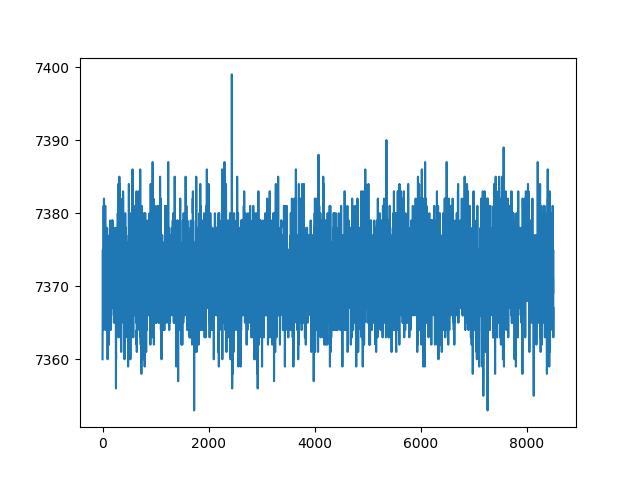

In [86]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(wf_b.sample_id, wf_b[8])

In [1]:
import pandas as pd
pd.options.plotting.backend = "plotly"

df = pd.DataFrame(dict(a=[1,3,2], b=[3,2,1]))
fig = df.plot()
fig.show()

In [2]:
wf_b.sample_id

NameError: name 'wf_b' is not defined

In [4]:
from beampy import *

# We first create a new document for our presentation
# Remove quiet=True to see Beampy compiler output
doc = document(quiet=True)

# Then we create a new slide with the title "My first new slide"
with slide('My first slide title'):

    # All the slide contents are functions added inside the with statement.
    # Here we add a text content using the Beampy module text
    text('Hello Beampy!')

# At the end we save our presentation to an HTML file.
# The save command will launch the compilation of all slides of the
# presentation.
save('hello.html')

# If you want to save it to pdf just change the file extension.
# save('hello.pdf')

# This line is just for displaying the slide in this tutorial webpage
# Remove it in your presentation
display_matplotlib(gcs())

/Users/ale/Development/dune/trigger-studies/tpvalidator/.venv/lib/python3.13/site-packages/beampy/functions.py:28: SyntaxWarning:

invalid escape sequence '\s'

/Users/ale/Development/dune/trigger-studies/tpvalidator/.venv/lib/python3.13/site-packages/beampy/functions.py:28: SyntaxWarning:

invalid escape sequence '\s'



ModuleNotFoundError: No module named 'distutils'

In [6]:
import beampy

ModuleNotFoundError: No module named 'distutils'